#### Deformable Convolution Network Model from Junliangwangdhu to classify all defects (including none)
Implementation of the classification model from Junliangwangdhu [GitHub](https://github.com/Junliangwangdhu/WaferMap).

Data:
- Resized to 52x52 with no filter
- Nones randomly undersampled to 30,000
- Defects augmented with random flips and rotations

In [1]:
# !pip install pickle5

In [2]:
# import libraries
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
#from tensorflow.keras import datasets, layers, models, losses, optimizers, regularizers, callbacks, Input, Model, Sequential
from keras import datasets, layers, models, losses, optimizers, regularizers, callbacks, Input, Model, Sequential

import os
import time
import numpy as np
import pandas as pd

from layers_train import ConvOffset2D_train

import helpers as helper
from keras_model_s3_wrapper import *

import boto3
import pickle5 as pickle
s3 = boto3.resource('s3')
bucket_name = 'wafer-capstone'
my_bucket = s3.Bucket(bucket_name)

Using TensorFlow backend.


In [3]:
tf.__version__

'1.15.5'

In [4]:
# specify variables
path = 'processed_data/dcn'
filename = 'WM-clean-dcn52-undersampled-augmented'

result_path = 'results_dcn'
model_id = 'wmdcn'
data_id = '52-undersampled-augmented'
note = '' # -optional

In [5]:
# load dataset
from io import BytesIO
start = time.time()

data_key = f'{path}/{filename}.npz'
data_obj = my_bucket.Object(data_key).get()['Body'].read()
data = np.load(BytesIO(data_obj), allow_pickle=True)

print('Wall time: {:.3f} seconds'.format(time.time() - start))
data.files

Wall time: 0.427 seconds


['ids', 'labels', 'dataset', 'wafermap']

#### Data set-up

In [6]:
# prepare inputs
start = time.time()

x_train = data['wafermap'][data['dataset']=='train']
x_val = data['wafermap'][data['dataset']=='dev']
x_test = data['wafermap'][data['dataset']=='test']

print('Wall time: {:.3f} seconds'.format(time.time() - start))
print(f'Train: {x_train.shape}')
print(f'Dev: {x_val.shape}')
print(f'Test: {x_test.shape}')

Wall time: 4.229 seconds
Train: (47863, 52, 52)
Dev: (25942, 52, 52)
Test: (25943, 52, 52)


In [7]:
# expand tensor and create dummy dimension at axis 3
# images in greyscale, so no channel dimension
start = time.time()

x_train = np.expand_dims(x_train, axis=-1)
x_val = np.expand_dims(x_val, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

print("Wall time: {:.2f} seconds".format(time.time() - start))
# sanity check
# expected: TensorShape([#rows, xdim, ydim, 1])
x_train.shape

Wall time: 0.00 seconds


(47863, 52, 52, 1)

In [8]:
# prepare labels for supervised learning
# note: make sure labels are integers if using sparse categorical cross entropy
start = time.time()

y_train = data['labels'][data['dataset']=='train']
y_val = data['labels'][data['dataset']=='dev']
y_test = data['labels'][data['dataset']=='test']

print("Wall time: {:.2f} seconds".format(time.time() - start))
# sanity check
# expected: type = int, min = 0, max = 8
print(type(y_train[0]))
print(min(y_train), min(y_val), min(y_test))
print(max(y_train), max(y_val), max(y_test))

Wall time: 0.07 seconds
<class 'numpy.uint8'>
0 0 0
8 8 8


#### Model

In [9]:
# define model architecture

inputs=Input(shape=(52, 52, 1))
x = ConvOffset2D_train(1, name='conv_1_offset')(inputs)
x = layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same', name='conv_1')(x)
x = layers.BatchNormalization(axis=3, name='batch_normalization_1')(x)
x = layers.Activation('relu', name='activation_1')(x)

# Conv_2 layer
x = ConvOffset2D_train(32, name='conv_2_offset')(x)
x = layers.Conv2D(32*2, (3, 3), strides=(2, 2), padding='same', name='conv_2')(x)
x = layers.BatchNormalization(axis=3, name='batch_normalization_2')(x)
x = layers.Activation('relu', name='activation_2')(x)

# Conv_3 layer
x = ConvOffset2D_train(64, name='conv_3_offset')(x)
x = layers.Conv2D(32*4, (3, 3), strides=(2, 2), padding='same', name='conv_3')(x)
x = layers.BatchNormalization(axis=3, name='batch_normalization_3')(x)
x = layers.Activation('relu', name='activation_3')(x)

# Conv_4 layer
x = ConvOffset2D_train(128, name='conv_4_offset')(x)
x = layers.Conv2D(32*8, (3, 3), padding='same', name='conv_4')(x)
x = layers.BatchNormalization(axis=3, name='batch_normalization_4')(x)
x = layers.Activation('relu', name='activation_4')(x)

# Conv_5 layer
x = ConvOffset2D_train(256, name='conv_5_offset')(x)
x = layers.Conv2D(32*4, (3, 3), strides=(2, 2), padding='same', name='conv_5')(x)
x = layers.BatchNormalization(axis=3, name='batch_normalization_5')(x)
x = layers.Activation('relu', name='activation_5')(x)

# Pooling layer
x = layers.MaxPooling2D(3)(x)

# fc layer
x = layers.Flatten()(x)
outputs = layers.Dense(9, activation='softmax', name='fc')(x)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 52, 52, 1)         0         
_________________________________________________________________
conv_1_offset (ConvOffset2D_ (None, 52, 52, 1)         18        
_________________________________________________________________
conv_1 (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
conv_2_offset (ConvOffset2D_ (None, 26, 26, 32)        18432     
__________________________________________

In [10]:
# set model optimizer and metrics
opt = optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [ ]:
# run model
start = time.time()

history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=32, epochs=15)

print("Wall time: {:.2f} seconds".format(time.time() - start))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 47863 samples, validate on 25942 samples
Epoch 1/15
47863/47863 [==============================] - 309s 6ms/step - loss: 0.5051 - accuracy: 0.8527 - val_loss: 0.2750 - val_accuracy: 0.9421
Epoch 2/15
47863/47863 [==============================] - 308s 6ms/step - loss: 0.2868 - accuracy: 0.9108 - val_loss: 0.1559 - val_accuracy: 0.9566
Epoch 3/15
47863/47863 [==============================] - 309s 6ms/step - loss: 0.2337 - accuracy: 0.9256 - val_loss: 0.1654 - val_accuracy: 0.9560
Epoch 4/15
47863/47863 [==============================] - 309s 6ms/step - loss: 0.1965 - accuracy: 0.9379 - val_loss: 0.1727 - val_accuracy: 0.9561
Epoch 5/15
47863/47863 [==============================] - 308s 6ms/step - loss: 0.1671 - accuracy: 0.9466 - val_loss: 0.1572 - val_accuracy: 0.9568
Epoch 6/15
47863/47863 [==============================] - 309s 6ms/step - loss: 0.1435 - accuracy: 0.9547 - val_los

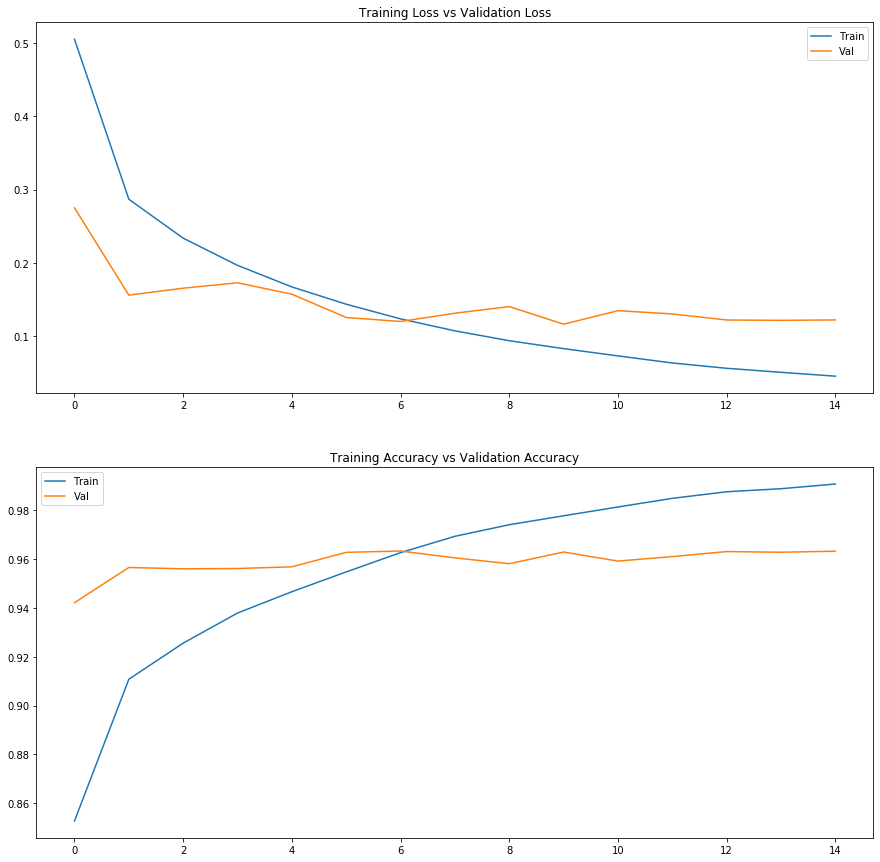

In [ ]:
# visualize accuracy and loss history
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].legend(['Train', 'Val'])

axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].legend(['Train', 'Val'])

#### Model results

In [ ]:
# save model to S3
s3_save_keras_model(model, f'{model_id}-{data_id}{note}')

In [ ]:
# compute model results on test set
start = time.time()
results = model.evaluate(x_test, y_test)
print("Wall time: {:.2f} seconds".format(time.time() - start))
print(results)

25943/25943 [==============================] - 37s 1ms/step
Wall time: 36.61 seconds
[0.12201621739070807, 0.9614154100418091]


In [ ]:
# generate predictions for model analysis
start = time.time()
y_pred = model.predict(x_test)
y_max = np.argmax(y_pred, axis=1).astype(np.uint8)
predictions = [y_max, y_pred]
print("Wall time: {:.2f} seconds".format(time.time() - start))

Wall time: 36.17 seconds


In [ ]:
# save predictions to local instance
with open(f'{result_path}/{model_id}-{data_id}{note}.pkl', "wb") as f:
    pickle.dump(predictions, f)

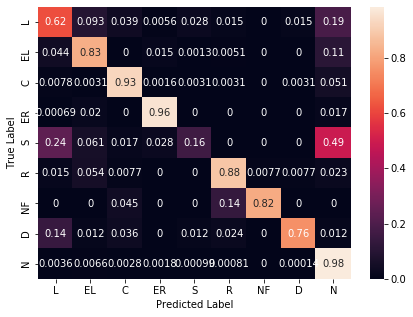

In [ ]:
# plot confusion matrix
helper.plot_confusion_matrix(y_test, y_max, mode='all', normalize=True)

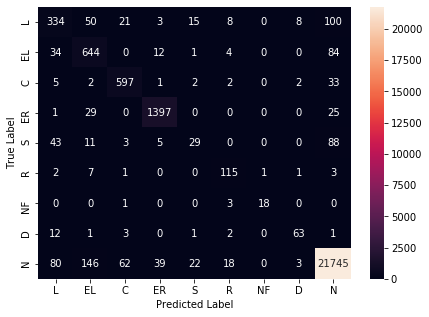

In [ ]:
# plot confusion matrix counts
helper.plot_confusion_matrix(y_test, y_max, mode='all', normalize=False)